In [ ]:
import sys
sys.path.insert(1, '../Src')
import numpy as np
import pandas as pd
import os
from utils.feature_engineering import *
from utils.preprocessing import *
from utils.analysis import *
import matplotlib.pyplot as plt
import os, sys, gc, time, warnings, pickle, psutil, random

from math import ceil

from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


warnings.filterwarnings('ignore')

PATH_DATASET = '../Dataset/'
#PATH_DATASET = '../Dataset/datah-m1-challange/'
PATH_RESULTS = '../Results/'

FILL = False

In [ ]:
SEED = 42

In [ ]:
seed_everything(SEED)

In [ ]:
print('Reading dataset')

df_sales  = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','df_sales_fe_FILL_'+str(FILL)+'_.pkl'))
df_submission_sample = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','df_submission_sample_fe_FILL_'+str(FILL)+'_.pkl'))

df_sales             = reduce_mem_usage(df_sales)
df_submission_sample = reduce_mem_usage(df_submission_sample)
gc.collect()
print('df_sales size             :',df_sales.shape)
print('df_submission_sample size :',df_submission_sample.shape) 

Reading dataset
Memory usage of dataframe is 815.47 MB
Memory usage after optimization is: 815.47 MB
Decreased by 0.0%
Memory usage of dataframe is 19.53 MB
Memory usage after optimization is: 19.53 MB
Decreased by 0.0%
df_sales size             : (2749369, 101)
df_submission_sample size : (69121, 102)


In [ ]:
df_submission_sample.head(2)

,ID,QTT,DATE,S100,I100,C100,C101,item_id,date_block_num,I101,...,enc_C101_mean,enc_C101_std,enc_S100_C100_mean,enc_S100_C100_std,enc_I100_C101_mean,enc_I100_C101_std,enc_I100_S100_mean,enc_I100_S100_std,enc_I100_C100_C101_mean,enc_I100_C100_C101_std
0,2021-10-03_0_1_12_140,-1,2021-10-03,0,1,12,140,1_12_140,247,2,...,0.656738,1.464844,0.213501,0.662109,0.548340,1.155273,0.419678,0.838379,0.446777,1.009766
1,2021-10-03_0_1_12_164,-1,2021-10-03,0,1,12,164,1_12_164,247,2,...,0.483398,1.599609,0.213501,0.662109,0.473145,1.088867,0.419678,0.838379,0.452881,1.040039


In [ ]:
features_names = set(df_sales.columns)-set(['QTT','DATE','item_id','ID', 'date_block_num']) 
print(len(features_names))

97


In [ ]:
X_train      = df_sales[(df_sales['DATE'] >= '2017-01-01') & (df_sales['DATE'] < '2021-05-01')].copy()
X_validation = df_sales[(df_sales['DATE'] >= '2021-05-01') & (df_sales['DATE'] < '2021-08-01')].copy()
X_test       = df_sales[(df_sales['DATE'] >= '2021-08-01') & (df_sales['DATE'] < '2021-10-03')].copy() 

y_train = X_train['QTT']
X_train = X_train[features_names]

y_validation = X_validation['QTT']
X_validation = X_validation[features_names]

y_test = X_test['QTT']
X_test = X_test[features_names]

y_submission = df_submission_sample['QTT']
X_submission = df_submission_sample[features_names]


print('X_train      ',X_train.shape)
print('y_validation ',y_validation.shape)
print('X_test       ',X_test.shape)
print('X_submission ',X_submission.shape)

X_train       (2511660, 97)
y_validation  (142194,)
X_test        (95515, 97)
X_submission  (69121, 97)


In [ ]:

hyper_params ={      
  'boosting_type': 'gbdt',
   'objective': 'tweedie',
   'tweedie_variance_power': 1.1,
    'metric': 'rmse',
    'subsample': 0.6,
    'subsample_freq': 1,
    'learning_rate': 0.02,
    'num_leaves': 2**11-1,
    'min_data_in_leaf': 2**12-1,
    'feature_fraction': 0.6,
    'max_bin': 100,
    'boost_from_average': False,
    'verbose': -1,
    'num_threads': 8
   }    

In [ ]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_validation, y_validation)

gbm2 = lgb.train(hyper_params, lgb_train, 3000, valid_sets=[lgb_train, lgb_valid],early_stopping_rounds=100, verbose_eval=50)


Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 2.78134	valid_1's rmse: 2.56065
[100]	training's rmse: 2.48543	valid_1's rmse: 2.33039
[150]	training's rmse: 2.37727	valid_1's rmse: 2.26759
[200]	training's rmse: 2.32885	valid_1's rmse: 2.2472
[250]	training's rmse: 2.29883	valid_1's rmse: 2.2412
[300]	training's rmse: 2.2783	valid_1's rmse: 2.23756
[350]	training's rmse: 2.26345	valid_1's rmse: 2.23617
[400]	training's rmse: 2.25167	valid_1's rmse: 2.23514
[450]	training's rmse: 2.24198	valid_1's rmse: 2.23494
[500]	training's rmse: 2.23331	valid_1's rmse: 2.23557
Early stopping, best iteration is:
[439]	training's rmse: 2.24379	valid_1's rmse: 2.23446


In [ ]:
X_submission = df_submission_sample[features_names]

In [ ]:
import numpy as np

model_version = 'model_v1'

In [ ]:
print('make predictions...')
X_train_pred      = gbm2.predict(X_train)#, num_iteration=gbm.best_iteration_)
X_validation_pred = gbm2.predict(X_validation)#, num_iteration=gbm.best_iteration_)
X_test_pred       = gbm2.predict(X_test)#, num_iteration=gbm.best_iteration_)



X_train_pred = np.maximum(X_train_pred, 0)
X_validation_pred = np.maximum(X_validation_pred, 0)
X_test_pred = np.maximum(X_test_pred, 0)


df_train_rmse = mean_squared_error(y_train,X_train_pred, squared=False)
df_val_rmse   = mean_squared_error(y_validation,X_validation_pred, squared=False)
df_test_rmse  = mean_squared_error(y_test,X_test_pred, squared=False)

print('Final score mean_squared_error')
print('Score train:',df_train_rmse)
print('Score val  :',df_val_rmse)
print('Score test :',df_test_rmse)


model_name = os.path.join(PATH_RESULTS,'lightgbm',model_version,'model_val_'+str(np.round(df_val_rmse,2))+'_test_'+str(np.round(df_test_rmse,2))+'.txt')
print('saving model..',model_name)
gbm2.save_model(model_name, num_iteration=gbm2.best_iteration)

make predictions...
Final score mean_squared_error
Score train: 2.2437894481939202
Score val  : 2.234458898221988
Score test : 2.8985282669350605
saving model.. ../Results/lightgbm/model_v1/model_val_2.23_test_2.9.txt


In [ ]:
X_submission_pred = gbm2.predict(X_submission.values)#, num_iteration=gbm.best_iteration_)
X_submission_pred = np.maximum(X_submission_pred, 0)


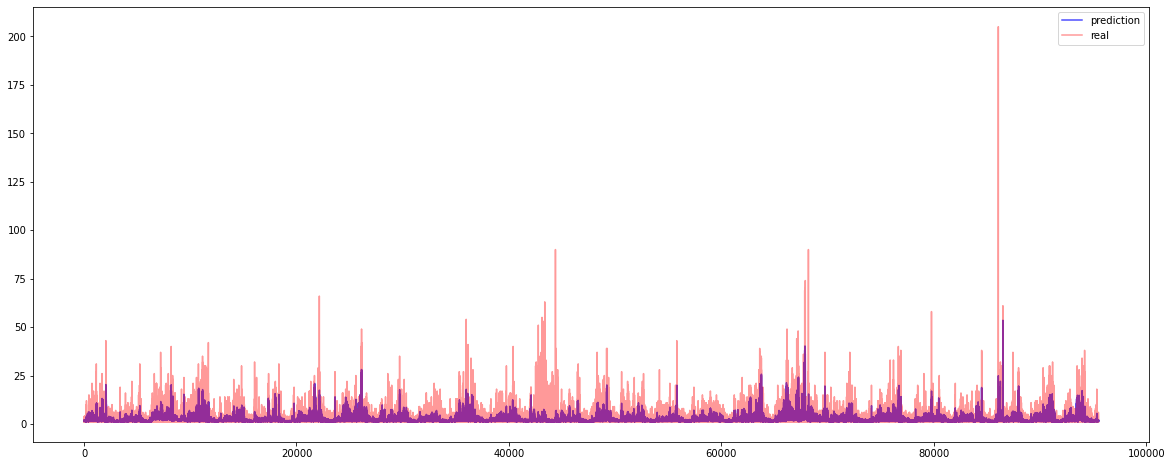

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,8))
plt.plot(X_test_pred,'b', alpha=0.7)
plt.plot(y_test.values,'r', alpha=0.4)
plt.legend(["prediction", "real"], loc ="upper right")

plt.show()

In [ ]:
df_submission_sample.reset_index(drop=True,inplace=True)
df_submission_sample['QTT'] = X_submission_pred
df_submission_sample.head()

,ID,QTT,DATE,S100,I100,C100,C101,item_id,date_block_num,I101,...,enc_C101_std,enc_S100_C100_mean,enc_S100_C100_std,enc_I100_C101_mean,enc_I100_C101_std,enc_I100_S100_mean,enc_I100_S100_std,enc_I100_C100_C101_mean,enc_I100_C100_C101_std,QTT_reference
0,2021-10-03_0_1_12_140,1.522361,2021-10-03,0,1,12,140,1_12_140,247,2,...,1.464844,0.213501,0.662109,0.548340,1.155273,0.419678,0.838379,0.446777,1.009766,1.373770
1,2021-10-03_0_1_12_164,1.643593,2021-10-03,0,1,12,164,1_12_164,247,2,...,1.599609,0.213501,0.662109,0.473145,1.088867,0.419678,0.838379,0.452881,1.040039,1.451087
2,2021-10-03_0_1_12_339,1.585133,2021-10-03,0,1,12,339,1_12_339,247,2,...,1.792969,0.213501,0.662109,0.458252,3.769531,0.419678,0.838379,0.311035,0.740234,1.311537
3,2021-10-03_0_1_13_128,1.467382,2021-10-03,0,1,13,128,1_13_128,247,2,...,0.896973,0.596191,1.528320,0.416748,0.942383,0.419678,0.838379,0.356201,0.763184,1.282604
4,2021-10-03_0_1_14_164,1.701950,2021-10-03,0,1,14,164,1_14_164,247,2,...,1.599609,0.700195,1.910156,0.473145,1.088867,0.419678,0.838379,0.470703,1.049805,1.673136


In [ ]:
filename_submission= 'sub_tr01_val_'+str(np.round(df_val_rmse,4))+'_test_'+str(np.round(df_test_rmse,4))+'_local.csv'
save = True
if save:
    print('saving..')
    print(filename_submission)
    df_submission_sample[['ID','QTT']].to_csv(os.path.join(PATH_RESULTS,'submissions',filename_submission),index=None)

saving..
sub_tr01_val_2.2345_test_2.8985_local.csv


In [ ]:
result = pd.read_csv(os.path.join(PATH_RESULTS,'submissions','submission_2.1046_local.csv'))

In [ ]:
df_submission_sample['QTT_reference']= result['QTT'].copy()
df_submission_sample[['QTT_reference','QTT']][-20:]

,QTT_reference,QTT
69101,3.906683,4.811972
69102,3.740769,5.005732
69103,0.067038,1.782319
69104,2.382908,1.815800
69105,59.378511,56.046650
69106,65.152742,44.028391
69107,80.167873,46.124386
69108,89.173996,36.464698
69109,89.656533,27.535499
69110,72.946618,24.799917


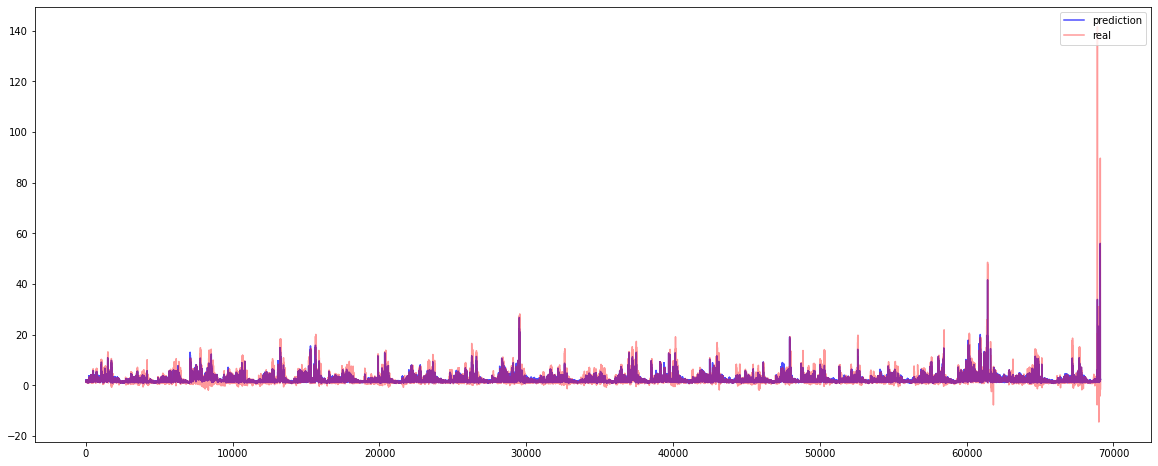

In [ ]:
fig = plt.figure(figsize=(20,8))
plt.plot(df_submission_sample['QTT'],'b', alpha=0.7)
plt.plot(result['QTT'],'r', alpha=0.4)
plt.legend(["prediction", "real"], loc ="upper right")
plt.show()

In [ ]:
difference = mean_squared_error(df_submission_sample['QTT'],result['QTT'], squared=False)

print('Final score mean_squared_error')
print('Score train:',difference)

Final score mean_squared_error
Score train: 1.155282561856013


In [ ]:
import numpy as np 
import pandas as pd 
import os
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
import datetime
import time
import sys

In [ ]:
X_train      = df_sales#[(df_sales['DATE'] >= '2017-01-01') & (df_sales['DATE'] < '2021-08-01')].copy()
#X_validation = df_sales[(df_sales['DATE'] >= '2021-05-01') & (df_sales['DATE'] < '2021-08-01')].copy()
#X_test       = df_sales[(df_sales['DATE'] >= '2021-08-01') & (df_sales['DATE'] <= '2021-10-03')].copy() 


y_train = X_train['QTT']
X_train = X_train[features_names]

#y_validation = X_validation['QTT']
#X_validation = X_validation[features_names]

#y_test = X_test['QTT']
#X_test = X_test[features_names]

y_submission = df_submission_sample['QTT']
X_submission = df_submission_sample[features_names]

In [ ]:
# set default parameters for 1st round training
params = {'boosting': 'gbdt',
          'objective':'regression',
          'metric': 'rmse',
          
          'learning_rate': 0.1, # 0.003! #0.005 #0.006 
          'num_leaves': 110, #110 #100 #150 large, but over-fitting
          'max_bin': 66,  #60 #50 # large,but slower,over-fitting
          'max_depth': 10, # deal with over-fitting
          'min_data_in_leaf': 30, # deal with over-fitting
          'min_child_samples': 20,
          'feature_fraction': 0.5,#0.5 #0.6 #0.8
          'bagging_fraction': 0.8,
          'bagging_freq': 40,#5  
          'bagging_seed': 11,
          'lambda_l1': 2,#1.3! #5 #1.2 #1
          'lambda_l2': 0.1 #0.1
         }


params ={      
   'device' : 'cpu',
    'boosting_type': 'gbdt',
   'objective': 'tweedie',
   'tweedie_variance_power': 1.1,
    'metric': 'rmse',
    'subsample': 0.6,
    'subsample_freq': 1,
    'learning_rate': 0.02,

    #'num_leaves': 200, #110 #100 #150 large, but over-fitting
    #'max_depth': 10, # deal with over-fitting
    #'min_data_in_leaf': 30, # deal with over-fitting
    
    'num_leaves': 2**11-1,
    'min_data_in_leaf': 2**12-1,
    
    'feature_fraction': 0.6,
    'max_bin': 100,
    #'n_estimators': …,   
    'boost_from_average': False,
    'verbose': -1,
    'num_threads': 8
   }    

In [ ]:
model_version = 'model_v2'

nfolds = 5

nrepeats = 2 
folds = RepeatedKFold(n_splits=nfolds, n_repeats=nrepeats, random_state=11)

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=nfolds, random_state=11, shuffle=True)
skf.get_n_splits(X_train, y_train)
print(skf)


fold_pred = np.zeros(len(X_train))


feature_importance_df = pd.DataFrame()

predictions_submission = pd.DataFrame()

lgb_preds = np.zeros(len(X_submission))

#for fold_, (trn_idx, val_idx) in enumerate(folds.split(y_train.values,y_train.values)):
for fold_, (trn_idx, val_idx) in enumerate(skf.split(y_train.values,y_train.values)):
    
    print(20*'*'," fold n°{}".format(fold_))
    
    trn_data = lgb.Dataset(X_train.iloc[trn_idx], label=y_train.iloc[trn_idx]) #categorical_feature=categorical_feats
    val_data = lgb.Dataset(X_train.iloc[val_idx], label=y_train.iloc[val_idx]) #categorical_feature=categorical_feats

    print('Training ...')
    iteration = 3000
    lgb_model = lgb.train(params, trn_data, iteration, valid_sets = [trn_data, val_data], verbose_eval=50, early_stopping_rounds = 100)
    
    print('make predictions...')
    #X_train_pred      = lgb_model.predict(X_train.iloc[trn_idx], num_iteration=lgb_model.best_iteration)
    X_validation_pred = lgb_model.predict(X_train.iloc[val_idx], num_iteration=lgb_model.best_iteration)
    #X_test_pred       = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

    #X_train_pred = np.maximum(X_train_pred, 0)
    X_validation_pred = np.maximum(X_validation_pred, 0)
    #X_test_pred = np.maximum(X_test_pred, 0)

    

    #df_train_rmse = mean_squared_error(y_train.iloc[trn_idx],X_train_pred, squared=False)
    df_val_rmse   = mean_squared_error(y_train.iloc[val_idx],X_validation_pred, squared=False)
    #df_test_rmse  = mean_squared_error(y_test,X_test_pred, squared=False)

    print('Final score mean_squared_error')
    #print('Score train:',df_train_rmse)
    print('Score val  :',df_val_rmse)
    #print('Score test :',df_test_rmse)


    fold_pred[val_idx] = X_validation_pred
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = X_train.columns
    fold_importance_df["importance"] = lgb_model.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    
    
    print('Predict submission ')
    X_submission_pred = lgb_model.predict(X_submission.values, num_iteration=lgb_model.best_iteration)
    X_submission_pred = np.maximum(X_submission_pred, 0)

    #lgb_preds += X_submission_pred / (nfolds*nrepeats)
    lgb_preds += X_submission_pred / (nfolds)
    
    predictions_submission[str(fold_ + 1)] = X_submission_pred
    
    
    model_name = os.path.join(PATH_RESULTS,'lightgbm',model_version,'model_fold_'+str(fold_ + 1)+'.txt')
    print('saving model..',model_name)
    lgb_model.save_model(model_name, num_iteration=lgb_model.best_iteration)
    
    #############################

print("CV score: {:<8.5f}".format(np.sqrt(mean_squared_error(fold_pred, y_train))))

StratifiedKFold(n_splits=5, random_state=11, shuffle=True)
********************  fold n°0
Training ...
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 2.79094	valid_1's rmse: 2.78293
[100]	training's rmse: 2.50696	valid_1's rmse: 2.50216
[150]	training's rmse: 2.40315	valid_1's rmse: 2.40358
[200]	training's rmse: 2.35723	valid_1's rmse: 2.36393
[250]	training's rmse: 2.32823	valid_1's rmse: 2.33968
[300]	training's rmse: 2.30649	valid_1's rmse: 2.32221
[350]	training's rmse: 2.2901	valid_1's rmse: 2.30892
[400]	training's rmse: 2.27658	valid_1's rmse: 2.29807
[450]	training's rmse: 2.26596	valid_1's rmse: 2.2899
[500]	training's rmse: 2.25601	valid_1's rmse: 2.28185
[550]	training's rmse: 2.24687	valid_1's rmse: 2.27533
[600]	training's rmse: 2.24001	valid_1's rmse: 2.2706
[650]	training's rmse: 2.23317	valid_1's rmse: 2.2654
[700]	training's rmse: 2.22636	valid_1's rmse: 2.26
[750]	training's rmse: 2.22091	valid_1's rmse: 2.25695
[800]	training's r

In [ ]:
cv_score = np.sqrt(mean_squared_error(fold_pred, y_train))

In [ ]:
# ranking all feature by avg importance score from Kfold, select top100
all_features = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)
all_features.reset_index(inplace=True)
important_features = list(all_features[0:30]['feature'])
all_features[0:30]

,feature,importance
0,day_of_year,33753.6
1,enc_I100_S100_std,22560.8
2,enc_I100_C100_C101_std,20490.0
3,I100,19048.0
4,enc_I100_S100_mean,17648.4
5,enc_I100_C101_std,16828.8
6,day,16600.0
7,enc_I100_C100_C101_mean,16269.0
8,C101,15723.0
9,rolling_mean_tmp_I100_1_7,15658.2


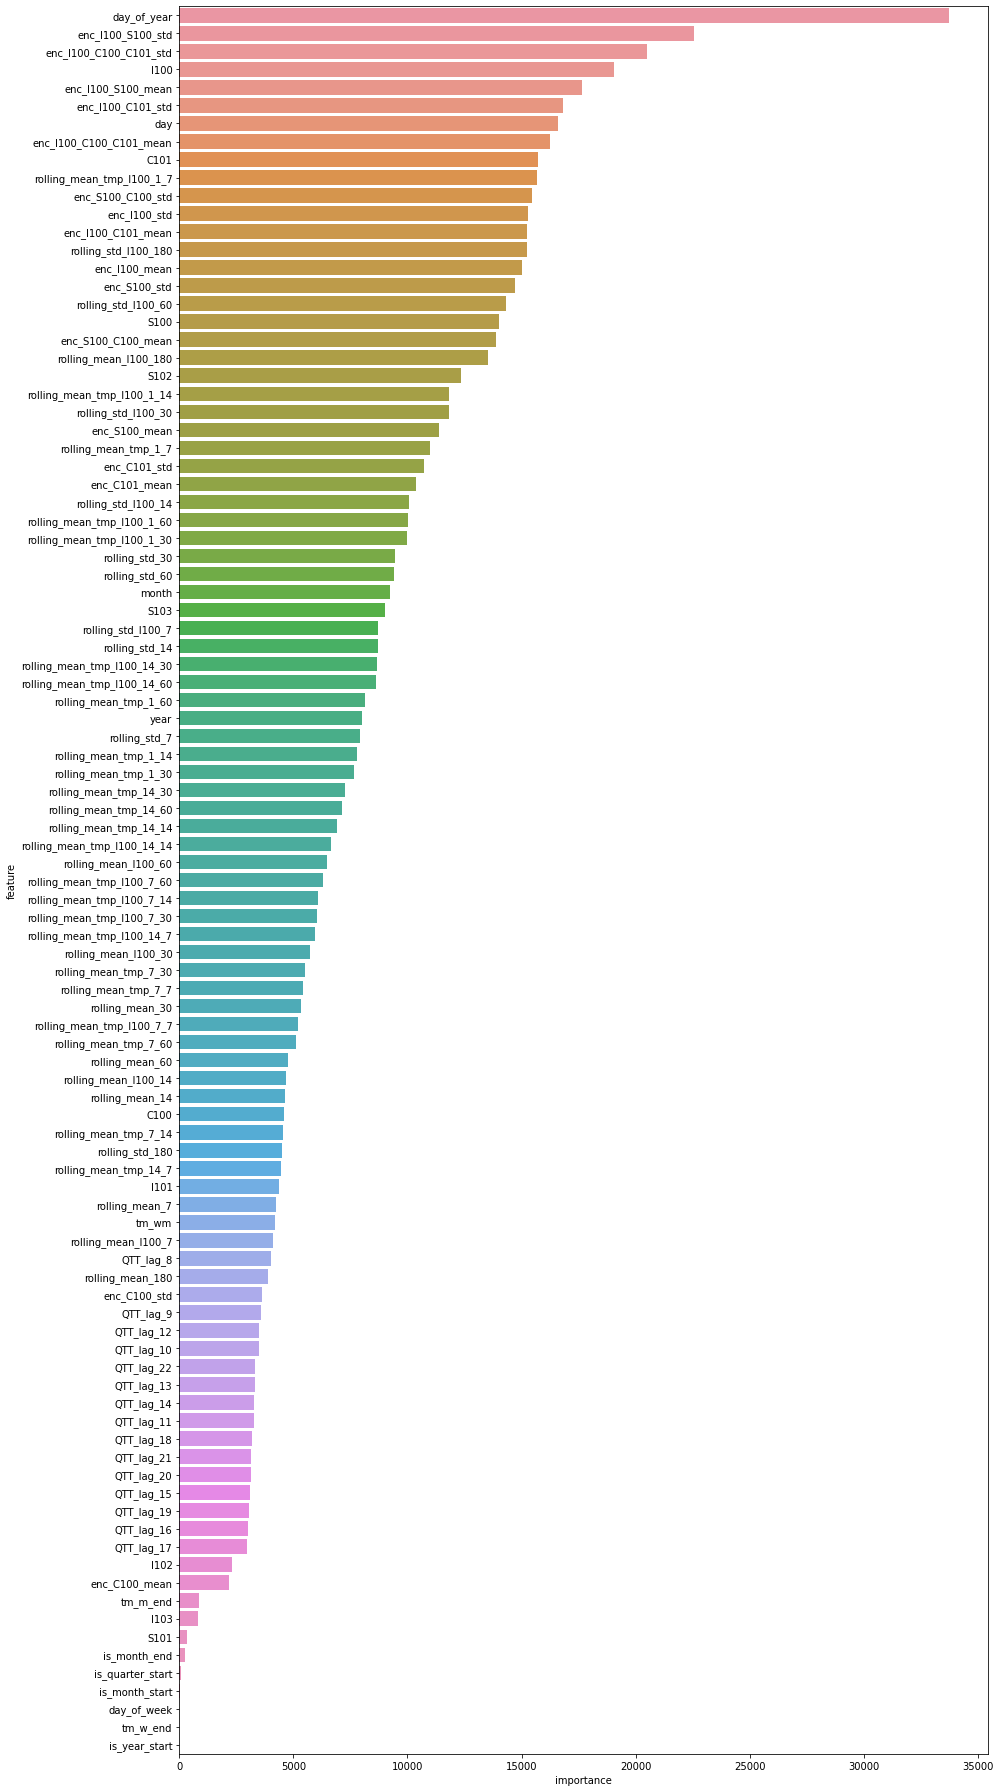

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,25))
sns.barplot(x="importance",y="feature",data=all_features)
plt.tight_layout()
plt.savefig(os.path.join(PATH_RESULTS,'all_data_lgbm_importances.png'))

In [ ]:
df_submission_sample.reset_index(drop=True,inplace=True)
df_submission_sample['QTT'] = predictions_submission.mean(axis=1)
df_submission_sample.head()

,ID,QTT,DATE,S100,I100,C100,C101,item_id,date_block_num,I101,...,enc_C101_std,enc_S100_C100_mean,enc_S100_C100_std,enc_I100_C101_mean,enc_I100_C101_std,enc_I100_S100_mean,enc_I100_S100_std,enc_I100_C100_C101_mean,enc_I100_C100_C101_std,QTT_reference
0,2021-10-03_0_1_12_140,1.305830,2021-10-03,0,1,12,140,1_12_140,247,2,...,1.464844,0.213501,0.662109,0.548340,1.155273,0.419678,0.838379,0.446777,1.009766,1.373770
1,2021-10-03_0_1_12_164,1.557606,2021-10-03,0,1,12,164,1_12_164,247,2,...,1.599609,0.213501,0.662109,0.473145,1.088867,0.419678,0.838379,0.452881,1.040039,1.451087
2,2021-10-03_0_1_12_339,1.470997,2021-10-03,0,1,12,339,1_12_339,247,2,...,1.792969,0.213501,0.662109,0.458252,3.769531,0.419678,0.838379,0.311035,0.740234,1.311537
3,2021-10-03_0_1_13_128,1.408705,2021-10-03,0,1,13,128,1_13_128,247,2,...,0.896973,0.596191,1.528320,0.416748,0.942383,0.419678,0.838379,0.356201,0.763184,1.282604
4,2021-10-03_0_1_14_164,1.654000,2021-10-03,0,1,14,164,1_14_164,247,2,...,1.599609,0.700195,1.910156,0.473145,1.088867,0.419678,0.838379,0.470703,1.049805,1.673136


saving..
training_sub_model_v2_cv_2.1961_local.csv


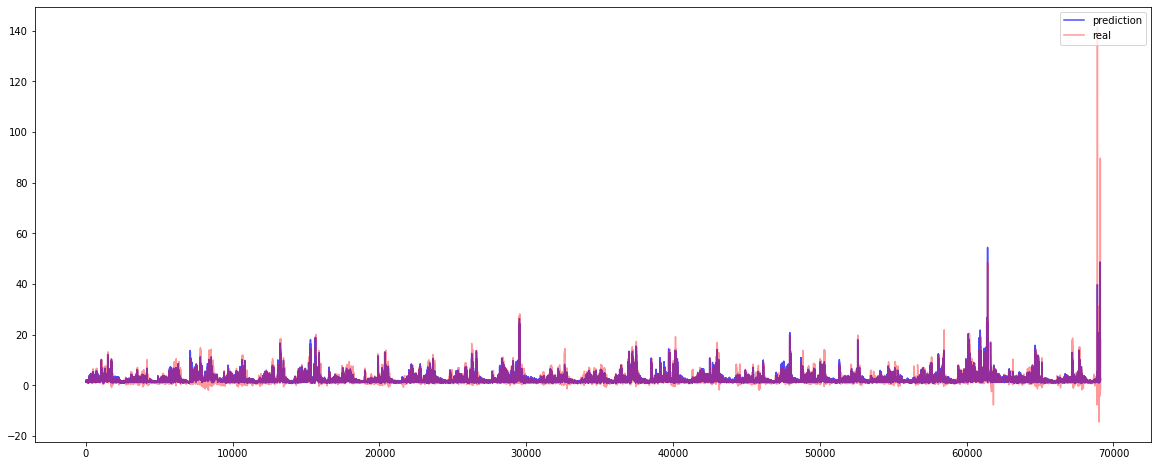

Final score mean_squared_error
Score train: 1.0708245742316334


In [ ]:
save = True
if save:
    filename_submission= 'training_sub_'+model_version+'_cv_'+str(np.round(cv_score,4))+'_local.csv'
    print('saving..')
    print(filename_submission)
    df_submission_sample[['ID','QTT']].to_csv(os.path.join(PATH_RESULTS,'submissions',filename_submission),index=None)
    
###################
result = pd.read_csv(os.path.join(PATH_RESULTS,'submissions','submission_2.1046_local.csv'))

df_submission_sample['QTT_reference']= result['QTT'].copy()
df_submission_sample[['QTT_reference','QTT']][-20:]

fig = plt.figure(figsize=(20,8))
plt.plot(df_submission_sample['QTT'],'b', alpha=0.7)
plt.plot(result['QTT'],'r', alpha=0.4)
plt.legend(["prediction", "real"], loc ="upper right")
plt.show()

#######
difference = mean_squared_error(df_submission_sample['QTT'],result['QTT'], squared=False)

print('Final score mean_squared_error')
print('Score train:',difference)


In [ ]:
features_names = important_features


X_train      = df_sales#[(df_sales['DATE'] >= '2017-01-01') & (df_sales['DATE'] < '2021-08-01')].copy()
#X_validation = df_sales[(df_sales['DATE'] >= '2021-05-01') & (df_sales['DATE'] < '2021-08-01')].copy()
#X_test       = df_sales[(df_sales['DATE'] >= '2021-08-01') & (df_sales['DATE'] <= '2021-10-03')].copy() 


y_train = X_train['QTT']
X_train = X_train[features_names]

#y_validation = X_validation['QTT']
#X_validation = X_validation[features_names]

#y_test = X_test['QTT']
#X_test = X_test[features_names]

y_submission = df_submission_sample['QTT']
X_submission = df_submission_sample[features_names]


In [ ]:
model_version = 'model_v3'

nfolds = 5

nrepeats = 2 

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=nfolds, random_state=11, shuffle=True)
skf.get_n_splits(X_train, y_train)
print(skf)
    
folds = RepeatedKFold(n_splits=nfolds, n_repeats=nrepeats, random_state=11)


fold_pred_fi = np.zeros(len(X_train))


feature_importance_df_fi = pd.DataFrame()
predictions_submission_fi = pd.DataFrame()

lgb_preds_fi = np.zeros(len(X_submission))

#for fold_, (trn_idx, val_idx) in enumerate(folds.split(y_train.values,y_train.values)):
for fold_, (trn_idx, val_idx) in enumerate(skf.split(y_train.values,y_train.values)):
    
    print(20*'*'," fold n°{}".format(fold_))
    
    trn_data = lgb.Dataset(X_train.iloc[trn_idx], label=y_train.iloc[trn_idx]) #categorical_feature=categorical_feats
    val_data = lgb.Dataset(X_train.iloc[val_idx], label=y_train.iloc[val_idx]) #categorical_feature=categorical_feats

    print('Training ...')
    iteration = 3000
    lgb_model = lgb.train(params, trn_data, iteration, valid_sets = [trn_data, val_data], verbose_eval=50, early_stopping_rounds = 100)
    
    print('make predictions...')
    #X_train_pred      = lgb_model.predict(X_train.iloc[trn_idx], num_iteration=lgb_model.best_iteration)
    X_validation_pred = lgb_model.predict(X_train.iloc[val_idx], num_iteration=lgb_model.best_iteration)
    #X_test_pred       = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

    #X_train_pred = np.maximum(X_train_pred, 0)
    X_validation_pred = np.maximum(X_validation_pred, 0)
    #X_test_pred = np.maximum(X_test_pred, 0)

    

    #df_train_rmse = mean_squared_error(y_train.iloc[trn_idx],X_train_pred, squared=False)
    df_val_rmse   = mean_squared_error(y_train.iloc[val_idx],X_validation_pred, squared=False)
    #df_test_rmse  = mean_squared_error(y_test,X_test_pred, squared=False)

    print('Final score mean_squared_error')
    #print('Score train:',df_train_rmse)
    print('Score val  :',df_val_rmse)
    #print('Score test :',df_test_rmse)


    fold_pred_fi[val_idx] = X_validation_pred
    
    fold_importance_df_fi = pd.DataFrame()
    fold_importance_df_fi["feature"] = X_train.columns
    fold_importance_df_fi["importance"] = lgb_model.feature_importance()
    fold_importance_df_fi["fold"] = fold_ + 1
    feature_importance_df_fi = pd.concat([feature_importance_df_fi, fold_importance_df_fi], axis=0)
    
    
    
    print('Predict submission ')
    X_submission_pred = lgb_model.predict(X_submission.values, num_iteration=lgb_model.best_iteration)
    X_submission_pred = np.maximum(X_submission_pred, 0)

    #lgb_preds_fi += X_submission_pred / (nfolds*nrepeats)
    lgb_preds_fi += X_submission_pred / (nfolds)
    
    predictions_submission_fi[str(fold_ + 1)] = X_submission_pred
    
    
    model_name = os.path.join(PATH_RESULTS,'lightgbm',model_version,'model_fold_'+str(fold_ + 1)+'.txt')
    print('saving model..',model_name)
    lgb_model.save_model(model_name, num_iteration=lgb_model.best_iteration)
    
    #############################

print("CV score: {:<8.5f}".format(np.sqrt(mean_squared_error(fold_pred_fi, y_train))))

StratifiedKFold(n_splits=5, random_state=11, shuffle=True)
********************  fold n°0
Training ...
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 2.79489	valid_1's rmse: 2.78614
[100]	training's rmse: 2.51354	valid_1's rmse: 2.50683
[150]	training's rmse: 2.41614	valid_1's rmse: 2.41243
[200]	training's rmse: 2.37373	valid_1's rmse: 2.37306
[250]	training's rmse: 2.34878	valid_1's rmse: 2.35058
[300]	training's rmse: 2.32669	valid_1's rmse: 2.33101
[350]	training's rmse: 2.30974	valid_1's rmse: 2.31608
[400]	training's rmse: 2.29567	valid_1's rmse: 2.30433
[450]	training's rmse: 2.28311	valid_1's rmse: 2.29406
[500]	training's rmse: 2.27319	valid_1's rmse: 2.28613
[550]	training's rmse: 2.26415	valid_1's rmse: 2.27869
[600]	training's rmse: 2.25706	valid_1's rmse: 2.27319
[650]	training's rmse: 2.24971	valid_1's rmse: 2.26755
[700]	training's rmse: 2.24407	valid_1's rmse: 2.26315
[750]	training's rmse: 2.23849	valid_1's rmse: 2.25914
[800]	train

In [ ]:
# predicted value distribution
import matplotlib.pyplot as plt

num_bins = 100
n, bins, patches = plt.hist(lgb_preds_fi, num_bins, facecolor='blue', alpha=0.5)
plt.show()

In [ ]:
# feature importance
final_importance_fi = feature_importance_df_fi[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)
final_importance_fi.reset_index(inplace=True)
final_importance_fi

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,25))
sns.barplot(x="importance",y="feature",data=final_importance_fi)
plt.tight_layout()
plt.savefig(os.path.join(PATH_RESULTS,'lgbm_importances.png'))

In [ ]:
df_submission_sample.reset_index(drop=True,inplace=True)
df_submission_sample['QTT'] = predictions_submission_fi.mean(axis=1)
df_submission_sample.head()

In [ ]:
save = True
if save:
    filename_submission= 'training_sub_'+model_version+'_cv_'+str(np.round(cv_score,4))+'_local.csv'
    print('saving..')
    print(filename_submission)
    df_submission_sample[['ID','QTT']].to_csv(os.path.join(PATH_RESULTS,'submissions',filename_submission),index=None)
    
###################
result = pd.read_csv(os.path.join(PATH_RESULTS,'submissions','submission_2.1046_local.csv'))

df_submission_sample['QTT_reference']= result['QTT'].copy()
df_submission_sample[['QTT_reference','QTT']][-20:]

fig = plt.figure(figsize=(20,8))
plt.plot(df_submission_sample['QTT'],'b', alpha=0.7)
plt.plot(result['QTT'],'r', alpha=0.4)
plt.legend(["prediction", "real"], loc ="upper right")
plt.show()

#######
difference = mean_squared_error(df_submission_sample['QTT'],result['QTT'], squared=False)

print('Final score mean_squared_error')
print('Score train:',difference)
